In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class UnpairedDataset(Dataset):
    def __init__(self, rootA, rootB, transform):
        self.A_paths = sorted(os.listdir(rootA))
        self.B_paths = sorted(os.listdir(rootB))
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return max(len(self.A_paths), len(self.B_paths))

    def __getitem__(self, idx):
        img_A = Image.open(os.path.join(self.rootA, self.A_paths[idx % len(self.A_paths)])).convert("RGB")
        img_B = Image.open(os.path.join(self.rootB, self.B_paths[idx % len(self.B_paths)])).convert("RGB")
        return {
            'A': self.transform(img_A),
            'B': self.transform(img_B)
        }

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = UnpairedDataset(
    "/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA",
    "/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainB_ghibli",
    transform
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [3]:
# Generator
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
        ]
        for _ in range(n_blocks):
            model += [ResnetBlock(256)]
        model += [
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)




In [4]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        ]

        for _ in range(n_blocks):
            model += [ResnetBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, 1, 1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [6]:
G_AB = Generator(3, 3).to(device)
G_BA = Generator(3, 3).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

loss_GAN = nn.MSELoss()
loss_cycle = nn.L1Loss()
loss_idt = nn.L1Loss()

opt_G = torch.optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=2e-4, betas=(0.5, 0.999))


In [7]:
for epoch in range(50):  # tăng lên 100 nếu bạn muốn
    for batch in dataloader:
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # ---- Generator ----
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)

        idt_A = G_BA(real_A)
        idt_B = G_AB(real_B)

        loss_id = loss_idt(idt_A, real_A) + loss_idt(idt_B, real_B)
        loss_cyc = loss_cycle(rec_A, real_A) + loss_cycle(rec_B, real_B)

        pred_fake_B = D_B(fake_B)
        loss_GAN_AB = loss_GAN(pred_fake_B, torch.ones_like(pred_fake_B))

        pred_fake_A = D_A(fake_A)
        loss_GAN_BA = loss_GAN(pred_fake_A, torch.ones_like(pred_fake_A))

        loss_G = loss_GAN_AB + loss_GAN_BA + 10 * loss_cyc + 5 * loss_id

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # ---- Discriminator A ----
        loss_D_A = 0.5 * (loss_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) +
                          loss_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A))))
        opt_D.zero_grad()
        loss_D_A.backward()
        opt_D.step()

        # ---- Discriminator B ----
        loss_D_B = 0.5 * (loss_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) +
                          loss_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B))))
        opt_D.zero_grad()
        loss_D_B.backward()
        opt_D.step()

    print(f"Epoch {epoch+1}: G_loss = {loss_G.item():.4f}")


Epoch 1: G_loss = 5.0043
Epoch 2: G_loss = 6.7980
Epoch 3: G_loss = 5.7837
Epoch 4: G_loss = 5.7424
Epoch 5: G_loss = 5.0461
Epoch 6: G_loss = 5.0212
Epoch 7: G_loss = 3.8170
Epoch 8: G_loss = 6.1885
Epoch 9: G_loss = 4.7879
Epoch 10: G_loss = 5.6299
Epoch 11: G_loss = 4.0680
Epoch 12: G_loss = 6.6021
Epoch 13: G_loss = 4.3962
Epoch 14: G_loss = 4.3299
Epoch 15: G_loss = 3.6000
Epoch 16: G_loss = 4.4670
Epoch 17: G_loss = 5.3068
Epoch 18: G_loss = 3.4090
Epoch 19: G_loss = 3.9659
Epoch 20: G_loss = 3.8535
Epoch 21: G_loss = 3.8853
Epoch 22: G_loss = 4.5241
Epoch 23: G_loss = 6.4597
Epoch 24: G_loss = 4.5255
Epoch 25: G_loss = 3.9923
Epoch 26: G_loss = 4.9890
Epoch 27: G_loss = 3.5089
Epoch 28: G_loss = 5.0204
Epoch 29: G_loss = 3.8765
Epoch 30: G_loss = 4.4523
Epoch 31: G_loss = 3.8171
Epoch 32: G_loss = 2.9324
Epoch 33: G_loss = 3.6945
Epoch 34: G_loss = 3.0318
Epoch 35: G_loss = 3.2494
Epoch 36: G_loss = 4.4058
Epoch 37: G_loss = 3.7922
Epoch 38: G_loss = 3.7096
Epoch 39: G_loss = 4.

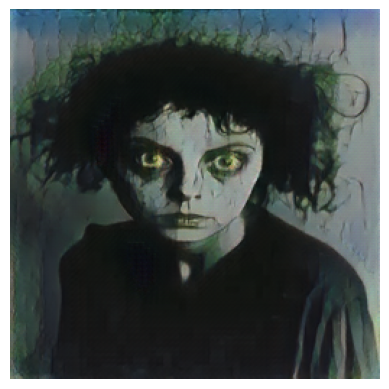

In [8]:
def show_image(tensor):
    img = (tensor[0].detach().cpu() + 1) / 2
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

real_A = next(iter(dataloader))['A'].to(device)
fake_B = G_AB(real_A)
show_image(fake_B)


In [9]:
torch.save(G_AB.state_dict(), "G_AB.pth")
torch.save(G_BA.state_dict(), "G_BA.pth")
